# Hidden Markov Model for Hangman

This notebook implements the HMM component of the intelligent Hangman agent.

## Approach:
- Train separate HMMs for different word lengths
- Hidden states: Letter positions in words
- Emissions: The actual letters at each position
- Use the trained HMM to predict letter probabilities for partially revealed words

In [3]:
import numpy as np
import pickle
from collections import defaultdict, Counter
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load and Analyze the Corpus

In [4]:
# Load the corpus
with open('Data/Data/corpus.txt', 'r') as f:
    corpus = [line.strip().lower() for line in f if line.strip()]

print(f"Total words in corpus: {len(corpus)}")
print(f"Sample words: {corpus[:10]}")

# Analyze word length distribution
word_lengths = [len(word) for word in corpus]
length_dist = Counter(word_lengths)

print(f"\nWord length distribution:")
for length in sorted(length_dist.keys())[:15]:
    print(f"Length {length}: {length_dist[length]} words")

Total words in corpus: 50000
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']

Word length distribution:
Length 1: 46 words
Length 2: 84 words
Length 3: 388 words
Length 4: 1169 words
Length 5: 2340 words
Length 6: 3755 words
Length 7: 5111 words
Length 8: 6348 words
Length 9: 6808 words
Length 10: 6465 words
Length 11: 5452 words
Length 12: 4292 words
Length 13: 3094 words
Length 14: 2019 words
Length 15: 1226 words


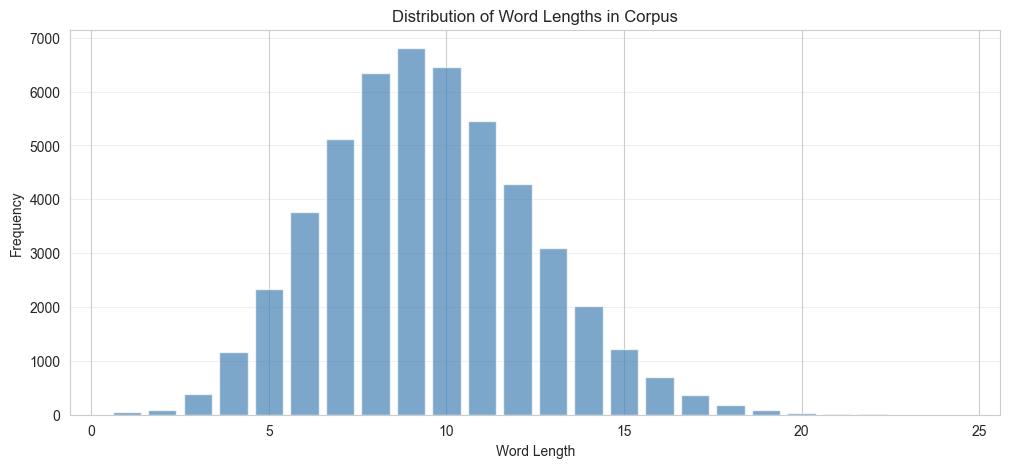

In [10]:
# Visualize word length distribution
plt.figure(figsize=(12, 5))
lengths = sorted(length_dist.keys())
counts = [length_dist[l] for l in lengths]
plt.bar(lengths, counts, color='steelblue', alpha=0.7)
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths in Corpus')
plt.grid(axis='y', alpha=0.3)
plt.show()

## 2. Build Position-Based Letter Frequency Models

For each word length, we'll track:
- Letter frequencies at each position
- Overall letter frequencies
- Pattern-based probabilities

In [11]:
class PositionalHMM:
    """A simplified HMM using positional letter frequencies"""
    
    def __init__(self):
        self.letter_freq_by_length = {}
        self.overall_freq_by_length = {}
        self.word_list_by_length = {}
        self.all_letters = set('abcdefghijklmnopqrstuvwxyz')
        
    def train(self, corpus):
        """Train the model on the corpus"""
        print("Training Positional HMM...")
        
        for word in tqdm(corpus):
            word = word.lower()
            length = len(word)
            
            # Initialize if needed
            if length not in self.word_list_by_length:
                self.word_list_by_length[length] = []
                self.letter_freq_by_length[length] = {}
                self.overall_freq_by_length[length] = Counter()
            
            self.word_list_by_length[length].append(word)
            
            # Track positional frequencies
            for pos, letter in enumerate(word):
                if pos not in self.letter_freq_by_length[length]:
                    self.letter_freq_by_length[length][pos] = Counter()
                self.letter_freq_by_length[length][pos][letter] += 1
                self.overall_freq_by_length[length][letter] += 1
        
        print(f"Training complete! Learned patterns for {len(self.letter_freq_by_length)} different word lengths.")
    
    def get_letter_probabilities(self, masked_word, guessed_letters):
        """
        Given a masked word (e.g., '_pp__') and guessed letters,
        return probability distribution over remaining letters
        """
        length = len(masked_word)
        remaining_letters = self.all_letters - set(guessed_letters)
        
        if length not in self.word_list_by_length:
            # Fallback to overall English letter frequency
            return self._get_default_probabilities(remaining_letters)
        
        # Filter words matching the pattern
        matching_words = self._get_matching_words(masked_word, guessed_letters, length)
        
        if not matching_words:
            # Use positional frequencies as fallback
            return self._get_positional_probabilities(masked_word, remaining_letters, length)
        
        # Count letter frequencies in matching words
        letter_counts = Counter()
        for word in matching_words:
            for letter in set(word):
                if letter in remaining_letters:
                    letter_counts[letter] += 1
        
        # Convert to probabilities
        total = sum(letter_counts.values())
        if total == 0:
            return self._get_default_probabilities(remaining_letters)
        
        probabilities = {letter: count / total for letter, count in letter_counts.items()}
        
        # Add small probability for unobserved letters
        for letter in remaining_letters:
            if letter not in probabilities:
                probabilities[letter] = 1e-6
        
        return probabilities
    
    def _get_matching_words(self, masked_word, guessed_letters, length):
        """Find words matching the current pattern"""
        matching_words = []
        
        for word in self.word_list_by_length[length]:
            # Check if word matches the pattern
            if self._matches_pattern(word, masked_word, guessed_letters):
                matching_words.append(word)
        
        return matching_words
    
    def _matches_pattern(self, word, masked_word, guessed_letters):
        """Check if a word matches the masked pattern"""
        if len(word) != len(masked_word):
            return False
        
        for i, (w_char, m_char) in enumerate(zip(word, masked_word)):
            if m_char != '_':
                if w_char != m_char:
                    return False
            else:
                # This position is masked, ensure it wasn't guessed
                if w_char in guessed_letters:
                    return False
        
        return True
    
    def _get_positional_probabilities(self, masked_word, remaining_letters, length):
        """Get probabilities based on positional frequencies"""
        letter_scores = defaultdict(float)
        
        for pos, char in enumerate(masked_word):
            if char == '_':
                if pos in self.letter_freq_by_length[length]:
                    pos_freq = self.letter_freq_by_length[length][pos]
                    total = sum(pos_freq.values())
                    if total > 0:
                        for letter in remaining_letters:
                            letter_scores[letter] += pos_freq[letter] / total
        
        total_score = sum(letter_scores.values())
        if total_score == 0:
            return self._get_default_probabilities(remaining_letters)
        
        return {letter: score / total_score for letter, score in letter_scores.items()}
    
    def _get_default_probabilities(self, remaining_letters):
        """Default English letter frequencies"""
        default_freq = {
            'e': 0.127, 't': 0.091, 'a': 0.082, 'o': 0.075, 'i': 0.070,
            'n': 0.067, 's': 0.063, 'h': 0.061, 'r': 0.060, 'd': 0.043,
            'l': 0.040, 'c': 0.028, 'u': 0.028, 'm': 0.024, 'w': 0.024,
            'f': 0.022, 'g': 0.020, 'y': 0.020, 'p': 0.019, 'b': 0.015,
            'v': 0.010, 'k': 0.008, 'j': 0.002, 'x': 0.002, 'q': 0.001, 'z': 0.001
        }
        
        probabilities = {}
        for letter in remaining_letters:
            probabilities[letter] = default_freq.get(letter, 1e-6)
        
        total = sum(probabilities.values())
        return {letter: prob / total for letter, prob in probabilities.items()}
    
    def save(self, filename):
        """Save the trained model"""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {filename}")
    
    @staticmethod
    def load(filename):
        """Load a trained model"""
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {filename}")
        return model

## 3. Train the HMM

In [12]:
# Initialize and train the model
hmm = PositionalHMM()
hmm.train(corpus)

Training Positional HMM...


100%|██████████| 50000/50000 [00:00<00:00, 96542.31it/s] 

Training complete! Learned patterns for 24 different word lengths.


## 4. Test the HMM

In [13]:
# Test the model with some examples
test_cases = [
    ('_pp__', ['a', 'b', 'c']),
    ('____', ['x', 'y', 'z']),
    ('h___o', ['a', 'b', 'c']),
    ('_a__', ['e', 'i', 'o']),
]

for masked_word, guessed in test_cases:
    probs = hmm.get_letter_probabilities(masked_word, guessed)
    top_letters = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\nPattern: {masked_word} | Guessed: {guessed}")
    print("Top 5 predictions:")
    for letter, prob in top_letters:
        print(f"  {letter}: {prob:.4f}")


Pattern: _pp__ | Guessed: ['a', 'b', 'c']
Top 5 predictions:
  p: 0.3333
  i: 0.3333
  e: 0.3333
  y: 0.0000
  m: 0.0000

Pattern: ____ | Guessed: ['x', 'y', 'z']
Top 5 predictions:
  a: 0.1165
  e: 0.0862
  o: 0.0797
  t: 0.0644
  i: 0.0638

Pattern: h___o | Guessed: ['a', 'b', 'c']
Top 5 predictions:
  o: 0.2174
  h: 0.2174
  e: 0.1739
  l: 0.1739
  u: 0.0435

Pattern: _a__ | Guessed: ['e', 'i', 'o']
Top 5 predictions:
  a: 0.2755
  r: 0.0716
  t: 0.0672
  s: 0.0521
  p: 0.0499


## 5. Visualize Letter Frequencies

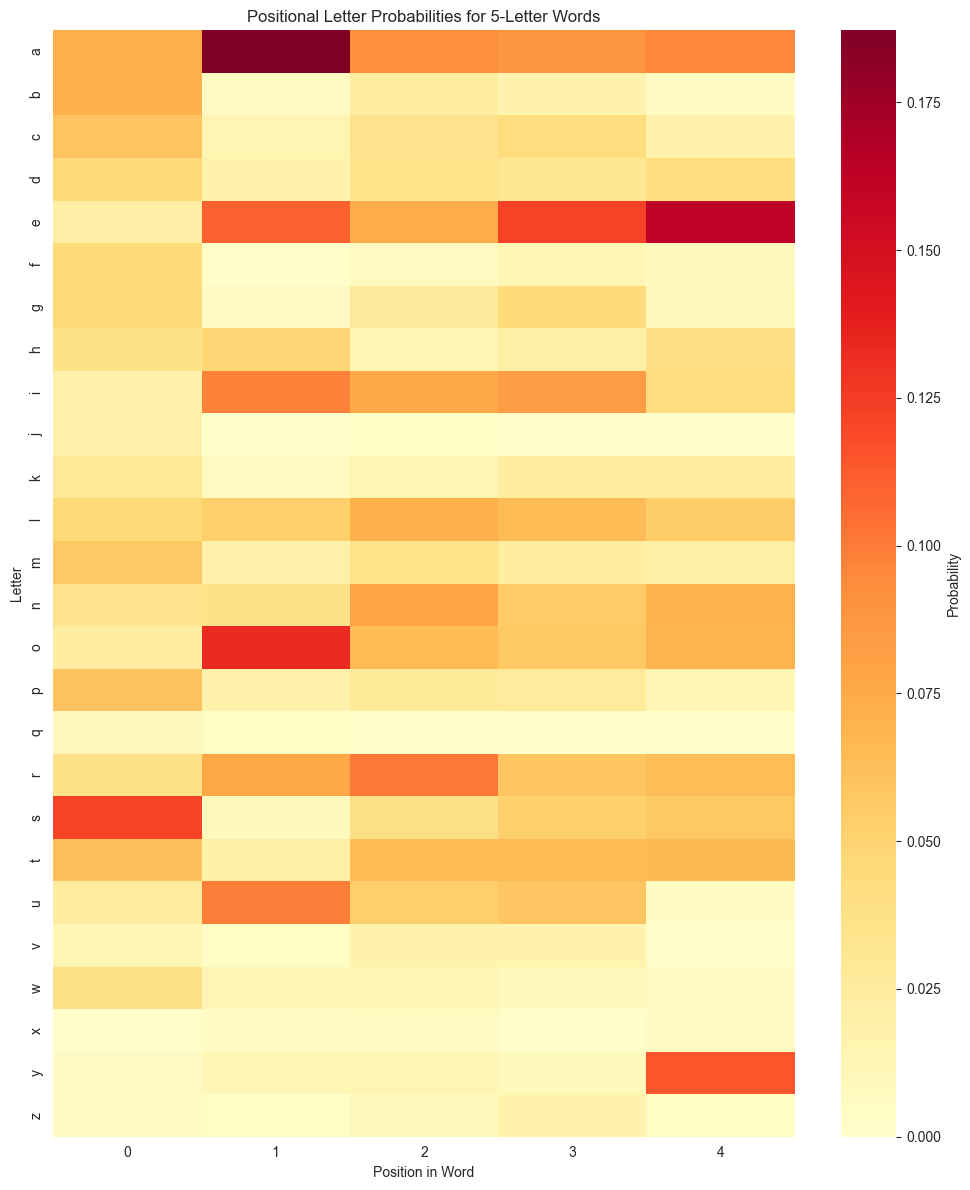

In [14]:
# Visualize positional letter frequencies for a specific word length
example_length = 5

if example_length in hmm.letter_freq_by_length:
    pos_data = hmm.letter_freq_by_length[example_length]
    
    # Create a heatmap
    letters = sorted(hmm.all_letters)
    positions = range(example_length)
    
    heatmap_data = np.zeros((len(letters), example_length))
    
    for i, letter in enumerate(letters):
        for pos in positions:
            heatmap_data[i, pos] = pos_data[pos][letter]
    
    # Normalize by position
    for pos in positions:
        col_sum = heatmap_data[:, pos].sum()
        if col_sum > 0:
            heatmap_data[:, pos] /= col_sum
    
    plt.figure(figsize=(10, 12))
    sns.heatmap(heatmap_data, xticklabels=positions, yticklabels=letters, 
                cmap='YlOrRd', cbar_kws={'label': 'Probability'})
    plt.xlabel('Position in Word')
    plt.ylabel('Letter')
    plt.title(f'Positional Letter Probabilities for {example_length}-Letter Words')
    plt.tight_layout()
    plt.show()

## 6. Save the Trained Model

In [15]:
# Save the model
hmm.save('hmm_model.pkl')
print("\nHMM training complete!")

Model saved to hmm_model.pkl

HMM training complete!


## Summary

The HMM has been successfully trained on the corpus. Key features:

1. **Positional Awareness**: Tracks letter frequencies at each position for different word lengths
2. **Pattern Matching**: Filters words matching the current game state
3. **Fallback Mechanisms**: Uses positional frequencies and default English letter frequencies when needed
4. **Probability Distribution**: Provides a probability distribution over remaining letters for the RL agent